<a href="https://colab.research.google.com/github/isabel-sha/ml-ai/blob/main/Scaled_Forecast_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weekly Forecast Model for Open, Closed, and Backlog Incidents in ServiceNow**

**1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
import time

sns.set_style("whitegrid")

**2. Load Data**

In [3]:
df = pd.read_csv("incident_combined.csv", encoding="ISO-8859-1")

# Convert date columns
date_cols = ['opened', 'closed']

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(
            df[col],
            format="%m/%d/%y %I:%M %p",
            errors="coerce"
        )

df.shape

(101722, 20)

**3. Aggregate Weekly**

In [4]:
# Week of opened incidents
df['week'] = df['opened'].dt.to_period('W').apply(lambda r: r.start_time)
opened_weekly = df.groupby('week').size().reset_index(name='opened')

# Week of closed incidents (directly using 'closed' field)
df['close_week'] = df['closed'].dt.to_period('W').apply(lambda r: r.start_time if pd.notnull(r) else pd.NaT)
closed_weekly = df.dropna(subset=['close_week']).groupby('close_week').size().reset_index(name='closed')

# Create complete weekly timeline
start_week = min(opened_weekly['week'].min(), closed_weekly['close_week'].min())
end_week = max(opened_weekly['week'].max(), closed_weekly['close_week'].max())
timeline = pd.DataFrame({'week': pd.date_range(start_week, end_week, freq='W-MON')})

timeline = timeline.merge(opened_weekly.rename(columns={'week':'week'}), on='week', how='left')
timeline = timeline.merge(closed_weekly.rename(columns={'close_week':'week'}), on='week', how='left')
timeline.fillna(0, inplace=True)

**4. Calculate Backlog**

In [5]:
current_backlog = df[df['active'] == True].shape[0]

timeline = timeline.sort_values('week').reset_index(drop=True)
timeline['backlog'] = np.nan
anchor_idx = timeline.index[-1]
timeline.loc[anchor_idx, 'backlog'] = current_backlog

for i in range(anchor_idx - 1, -1, -1):
    timeline.loc[i, 'backlog'] = (
        timeline.loc[i + 1, 'backlog']
        - timeline.loc[i + 1, 'opened']
        + timeline.loc[i + 1, 'closed']
    )

# Forward Backlog Calculation
timeline['backlog_forward'] = np.nan
timeline['backlog_forward'].iloc[0] = timeline['backlog'].iloc[0]

for i in range(1, len(timeline)):
    timeline['backlog_forward'].iloc[i] = (
        timeline['backlog_forward'].iloc[i-1]
        + timeline['opened'].iloc[i]
        - timeline['closed'].iloc[i]
    )

# Check Forward vs Actual Current Backlog
forward_last_week = timeline['backlog_forward'].iloc[-1]
actual_current_backlog = df[df['active'] == True].shape[0]

print("Forward Backlog Check")
print("-" * 40)
print(f"Calculated Forward Backlog (Last Week): {int(forward_last_week)}")
print(f"Actual Current Backlog: {int(actual_current_backlog)}")
print(f"Difference: {int(forward_last_week - actual_current_backlog)}")

print("\nFirst 5 Weeks Forward Backlog:")
print(timeline[['week','opened','closed','backlog_forward']].head())

Forward Backlog Check
----------------------------------------
Calculated Forward Backlog (Last Week): 2232
Actual Current Backlog: 2232
Difference: 0

First 5 Weeks Forward Backlog:
        week  opened  closed  backlog_forward
0 2021-07-12      61       1            -93.0
1 2021-07-19     551     293            165.0
2 2021-07-26     519     448            236.0
3 2021-08-02     547     478            305.0
4 2021-08-09     547     518            334.0


/tmp/ipython-input-1130981617.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timeline['backlog_forward'].iloc[0] = timeline['backlog'].iloc[0]
/tmp/ipython-input-1130981617.py:17: SettingWithCopyWarning: 
A value is trying to be set on

**5. Add Holidays**

In [6]:
def compute_holidays(df, date_cols=['opened', 'closed']):

    # --- Get min and max year across all date columns ---
    min_year = int(min(df[col].dropna().dt.year.min() for col in date_cols))
    max_year = int(max(df[col].dropna().dt.year.max() for col in date_cols)) + 1

    # --- Prepare US Holidays ---
    us_holidays = holidays.US(years=range(min_year, max_year), observed=False)
    allowed_holidays = {
        "New Year's Day", "Martin Luther King Jr. Day", "Memorial Day",
        "Juneteenth", "Independence Day", "Labor Day", "Veterans Day",
        "Thanksgiving Day", "Christmas Day"
    }

    def apply_observed(date):
        if date.weekday() == 5:
            return date - timedelta(days=1)
        elif date.weekday() == 6:
            return date + timedelta(days=1)
        return date

    def previous_weekday(d):
        while d.weekday() >= 5:
            d -= timedelta(days=1)
        return d

    def is_weekday(d):
        return d.weekday() < 5

    # --- Build holiday list ---
    holiday_rows = []
    for date, name in us_holidays.items():
        if name not in allowed_holidays and "Juneteenth" not in name:
            continue
        if "Juneteenth" in name and date.year < 2023:
            continue
        observed_date = apply_observed(date)
        holiday_rows.append((name, observed_date))

    # Thanksgiving Closure
    for date, name in us_holidays.items():
        if name == "Thanksgiving Day":
            observed = apply_observed(date)
            closure = apply_observed(observed + timedelta(days=1))
            holiday_rows.append(("Thanksgiving Closure", closure))

    # Christmas Eve
    for date, name in us_holidays.items():
        if name == "Christmas Day":
            christmas_eve = previous_weekday(date - timedelta(days=1))
            holiday_rows.append(("Christmas Eve", christmas_eve))

    # Winter Closure (4 weekdays after Christmas)
    for date, name in us_holidays.items():
        if name == "Christmas Day":
            observed = apply_observed(date)
            days_added = 0
            current = observed + timedelta(days=1)
            while days_added < 4:
                if is_weekday(current):
                    holiday_rows.append(("Winter Closure", current))
                    days_added += 1
                current += timedelta(days=1)

    # --- holiday_dates: raw holidays & closures ---
    holiday_df = pd.DataFrame(holiday_rows, columns=['holiday','date']).drop_duplicates()
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])

    # --- Compute incident counts for analysis ---
    results = holiday_df.copy()
    results['week'] = results['date'].dt.isocalendar().week
    results['year'] = results['date'].dt.isocalendar().year

    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df['_week'] = df[col].dt.isocalendar().week
        df['_year'] = df[col].dt.isocalendar().year

        # Exact incidents on each holiday date
        results[col + '_incidents'] = results['date'].apply(
            lambda d: (df[col].dt.date == d.date()).sum()
        )

        # Weekly incidents (count incidents in same week/year)
        results[col + '_week_incidents'] = results.apply(
            lambda row: ((df['_year'] == row['year']) & (df['_week'] == row['week'])).sum(),
            axis=1
        )

    # Combine multi-day closures in the same week/year
    combine_map = {
        "Winter Closure": ["Winter Closure","Christmas Day","Christmas Eve","New Year's Day"],
        "Thanksgiving Closure": ["Thanksgiving Day","Thanksgiving Closure"]
    }

    def get_combined_name(name):
        for combined_name, holidays_list in combine_map.items():
            if name in holidays_list:
                return combined_name
        return name

    results['holiday_combined'] = results['holiday'].apply(get_combined_name)

    holiday_counts_week = results.groupby(['year','week','holiday_combined'], as_index=False).agg({
        'date': 'min',
        **{col+'_incidents': 'sum' for col in date_cols},
        **{col+'_week_incidents': 'max' for col in date_cols}  # weekly incidents
    }).sort_values(['year','week']).reset_index(drop=True)

    df.drop(columns=['_year','_week'], inplace=True, errors='ignore')

    # --- RETURN BOTH ---
    return holiday_df, holiday_counts_week

# Compute holidays
holiday_df, holiday_counts_week = compute_holidays(df, date_cols=['opened','closed'])

# Use holiday_counts_week for analysis or reporting
non_zero_opened = holiday_counts_week[holiday_counts_week['opened_incidents'] != 0]
print(non_zero_opened[['date','week','opened_incidents','opened_week_incidents']])

non_zero_closed = holiday_counts_week[holiday_counts_week['closed_incidents'] != 0]
print(non_zero_closed[['date','week','closed_incidents','closed_week_incidents']])

         date  week  opened_incidents  opened_week_incidents
4  2021-09-06    36                20                    522
5  2021-11-11    45                32                    439
6  2021-11-25    47                17                    223
7  2021-12-24    51                 6                    161
8  2021-12-27    52                37                     46
9  2022-01-17     3               113                    695
10 2022-05-30    22                 5                    371
11 2022-07-04    27                 6                    356
12 2022-09-05    36                20                    428
13 2022-11-11    45                24                    458
14 2022-11-24    47                21                    296
15 2022-12-23    51                20                    276
16 2022-12-26    52                51                     53
17 2023-01-02     1                 5                    480
18 2023-01-16     3                 9                    373
19 2023-05-29    22     

**6. Feature Engineering**

In [7]:
def engineer_features(timeline, holiday_df):
    import numpy as np
    from datetime import timedelta

    timeline = timeline.copy()
    holiday_df = holiday_df.copy()

    # --- Map holiday & closure weeks ---
    holiday_df['week_start'] = holiday_df['date'].apply(
        lambda d: d - timedelta(days=d.weekday())
    )

    timeline['week_start'] = timeline['week'].apply(
        lambda d: d - timedelta(days=d.weekday())
    )

    closure_weeks = (
        holiday_df[holiday_df['holiday'].isin(['Winter Closure','Thanksgiving Closure'])]
        [['week_start']]
        .drop_duplicates()
        .assign(is_closure_week=1)
    )

    holiday_weeks = (
        holiday_df[['week_start']]
        .drop_duplicates()
        .assign(is_holiday_week=1)
    )

    timeline = timeline.merge(closure_weeks, on='week_start', how='left')
    timeline = timeline.merge(holiday_weeks, on='week_start', how='left')

    timeline['is_closure_week'] = timeline['is_closure_week'].fillna(0).astype(int)
    timeline['is_holiday_week'] = timeline['is_holiday_week'].fillna(0).astype(int)
    timeline.drop(columns='week_start', inplace=True)

    # --- Time features ---
    timeline['month'] = timeline['week'].dt.month
    timeline['weekday'] = timeline['week'].dt.weekday
    timeline['day_of_week'] = timeline['week'].dt.dayofweek
    timeline['weekofyear'] = timeline['week'].dt.isocalendar().week
    timeline['is_weekend'] = (timeline['weekday'] >= 5).astype(int)
    timeline['is_end_of_month'] = timeline['weekofyear'].isin([4,8,12,16,20,24,28]).astype(int)

    # January signal (IMPORTANT)
    timeline['is_january'] = (timeline['month'] == 1).astype(int)

    timeline['closure_weekend_interaction'] = (
        timeline['is_closure_week'] * timeline['is_weekend']
    )

    # --- Cyclical ---
    timeline['month_sin'] = np.sin(2*np.pi*timeline['month']/12)
    timeline['month_cos'] = np.cos(2*np.pi*timeline['month']/12)
    timeline['weekday_sin'] = np.sin(2*np.pi*timeline['weekday']/7)
    timeline['weekday_cos'] = np.cos(2*np.pi*timeline['weekday']/7)

    # --- Lag features ---
    timeline = timeline.sort_values('week').reset_index(drop=True)

    for lag in [1,2,3,7,14,28]:
        for col in ['opened','closed']:
            timeline[f'{col}_lag_{lag}'] = timeline[col].shift(lag)

    # --- Rolling ---
    for window in [3,4,7,14]:
        for col in ['opened','closed']:
            timeline[f'{col}_roll_{window}'] = (
                timeline[col].shift(1).rolling(window).mean()
            )

    # --- EWMA ---
    for window in [3,7,14,28]:
        for col in ['opened','closed']:
            timeline[f'{col}_ewma_{window}'] = (
                timeline[col].ewm(span=window, adjust=False).mean()
            )

    # --- Lag diffs ---
    for lag1, lag2 in [(1,3),(1,7),(3,14),(7,28)]:
        for col in ['opened','closed']:
            timeline[f'{col}_lag_{lag1}_lag_{lag2}_diff'] = (
                timeline[f'{col}_lag_{lag1}'] - timeline[f'{col}_lag_{lag2}']
            )

    timeline = timeline.dropna().reset_index(drop=True)

    BASE_FEATURES = [
        'month','weekday','weekofyear','day_of_week','is_weekend','is_end_of_month',
        'is_holiday_week','is_closure_week','closure_weekend_interaction',
        'is_january',
        'month_sin','month_cos','weekday_sin','weekday_cos'
    ]

    FEATURE_SETS = {
        'opened': [c for c in timeline.columns if c.startswith('opened_') or c in BASE_FEATURES],
        'closed': [c for c in timeline.columns if c.startswith('closed_') or c in BASE_FEATURES]
    }

    return timeline, FEATURE_SETS
timeline, FEATURE_SETS = engineer_features(timeline, holiday_df)

**7. Train/Test Split**

In [8]:
last_date = timeline['week'].max()
test_start = last_date - pd.Timedelta(days=180)  # ~6 months

train_df = timeline[timeline['week'] < test_start].copy()
test_df  = timeline[timeline['week'] >= test_start].copy()

**8. Feature Selection Function**

In [9]:
def select_best_num_features(
    target_col,
    FEATURE_SETS,
    train_df,
    min_features=5,
    max_features=20,
    step=1,
    patience=3
):
    # Define the time-based features you'd like to include
    seasonal_features = [
        'is_holiday_week', 'is_closure_week', 'is_january', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'is_weekend', 'is_end_of_month'
    ]

    # Combine the seasonal features with the existing ones
    features = FEATURE_SETS[target_col] + seasonal_features

    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize the GradientBoostingRegressor
    temp_gb = GradientBoostingRegressor(
        random_state=42,
        n_estimators=200,
        max_depth=3
    )

    # Fit the model to the initial set of features
    temp_gb.fit(train_df[features], train_df[target_col])

    # Get feature importances
    importances = (
        pd.Series(temp_gb.feature_importances_, index=features)
        .sort_values(ascending=False)
    )

    best_mae = float('inf')
    best_features = None
    no_improve_count = 0

    # Try different feature subsets and use cross-validation to evaluate them
    for n in range(min_features, min(max_features, len(features)) + 1, step):
        selected_features = importances.head(n).index.tolist()

        # Calculate the MAE using cross-validation
        cv_mae = -cross_val_score(
            temp_gb,
            train_df[selected_features],
            train_df[target_col],
            cv=tscv,
            scoring='neg_mean_absolute_error'
        ).mean()

        print(f"Top {n} features → CV MAE: {cv_mae:.3f}")

        if cv_mae < best_mae:
            best_mae = cv_mae
            best_features = selected_features
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping at {n} features (no improvement for {patience} steps)")
                break

    print(f"\n✅ Best features ({len(best_features)}):")
    print(best_features)

    return best_features


**9. Model Metric Functions**

In [10]:
def compute_metrics(name, model, X_train, y_train, X_test, y_test, tscv):
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.sqrt(mean_squared_error(y_test, preds))

    cv_scores = -cross_val_score(
        model, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    return {
        'model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'CV_MAE': cv_scores.mean(),
        'CV_STD': cv_scores.std()
    }


def naive_metrics(y_train, y_test):
    naive_test_pred = y_test.shift(1).dropna()
    naive_test_actual = y_test.iloc[1:]

    test_mae = mean_absolute_error(naive_test_actual, naive_test_pred)
    test_rmse = np.sqrt(mean_squared_error(naive_test_actual, naive_test_pred))

    naive_train_pred = y_train.shift(1).dropna()
    naive_train_actual = y_train.iloc[1:]
    cv_mae = mean_absolute_error(naive_train_actual, naive_train_pred)

    return {
        'model': 'NAIVE',
        'MAE': test_mae,
        'RMSE': test_rmse,
        'CV_MAE': cv_mae,
        'CV_STD': 0.0
    }

**10. Model Training and Evaluation Function**

In [11]:
def tune_and_evaluate_model(target_col, min_features=5, max_features=20):
    start_time = time.time()

    # --- Feature Selection ---
    selected_features = select_best_num_features(
      target_col,
      FEATURE_SETS,
      train_df,
      min_features=min_features,
      max_features=max_features
    )


    tscv = TimeSeriesSplit(n_splits=5)

    # --- Hyperparameter Grids ---
    rf_param_grid = {
      'n_estimators': [50, 100, 150],
      'max_depth': [10, 15, 20],
      'min_samples_split': [2, 5],
      'min_samples_leaf': [1, 3],
      'max_features': ['sqrt']
  }

    gb_param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5]
    }

    xgb_param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # --- Train Models and Time Them ---
    model_searches = {}

    for name, model_class, param_grid in [
        ('RF', RandomForestRegressor, rf_param_grid),
        ('GB', GradientBoostingRegressor, gb_param_grid),
        ('XGB', xgb.XGBRegressor, xgb_param_grid)
    ]:
        start = time.time()
        search = RandomizedSearchCV(
            model_class(random_state=42),
            param_grid,
            n_iter=10,
            cv=tscv,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=42
        )
        search.fit(train_df[selected_features], train_df[target_col])
        elapsed = time.time() - start
        print(f"⏱️ {name} training time: {elapsed:.2f}s")
        model_searches[name] = search

    # --- Predictions ---
    preds = {name: search.best_estimator_.predict(test_df[selected_features])
             for name, search in model_searches.items()}

    # --- Model Evaluation ---
    metrics = []
    for name, search in model_searches.items():
        start = time.time()
        metrics.append(
            compute_metrics(
                name, search.best_estimator_,
                train_df[selected_features], train_df[target_col],
                test_df[selected_features], test_df[target_col],
                tscv
            )
        )
        elapsed = time.time() - start
        print(f"⏱️ {name} metrics computation time: {elapsed:.2f}s")

    # --- Add Naive Baseline ---
    metrics.append(naive_metrics(train_df[target_col], test_df[target_col]))

    metrics_df = pd.DataFrame(metrics)
    metrics_df['MAE_rank'] = metrics_df['MAE'].rank()
    metrics_df['RMSE_rank'] = metrics_df['RMSE'].rank()
    metrics_df['MAPE_rank'] = metrics_df['MAPE'].rank()
    metrics_df['CV_MAE_rank'] = metrics_df['CV_MAE'].rank()
    metrics_df['CV_STD_rank'] = metrics_df['CV_STD'].rank()
    metrics_df['score'] = (
        metrics_df['MAE_rank'] * 0.30 +
        metrics_df['RMSE_rank'] * 0.20 +
        metrics_df['MAPE_rank'] * 0.20 +
        metrics_df['CV_MAE_rank'] * 0.25 +
        metrics_df['CV_STD_rank'] * 0.05
    )
    metrics_df['model'] = metrics_df['model'].apply(lambda x: f"{x} (Baseline)" if x == 'NAIVE' else x)

    # --- Select Best Model ---
    best_row = metrics_df.loc[metrics_df['score'].idxmin()]
    best_model_name = best_row['model']
    best_model = model_searches.get(best_model_name, None)
    if best_model is not None:
        best_model = best_model.best_estimator_

    total_time = time.time() - start_time
    print(f"\n⏱️ Total elapsed time: {total_time:.2f}s")

    # --- Display Results ---
    print("\n📊 MODEL COMPARISON")
    print(metrics_df.sort_values('score')[['model','MAE','RMSE','MAPE','CV_MAE','CV_STD','score']])

    print("\n🏆 BEST MODEL SELECTED")
    print("-" * 40)
    print(f"Target       : {target_col}")
    print(f"Model        : {best_model_name}")
    print(f"MAE          : {best_row['MAE']:.2f}")
    print(f"RMSE         : {best_row['RMSE']:.2f}")
    print(f"CV MAE       : {best_row['CV_MAE']:.2f} ± {best_row['CV_STD']:.2f}")
    print(f"Training Time: {total_time:.1f}s")

    # --- Plot Best Model ---
    y_true = test_df[target_col]
    y_pred = best_model.predict(test_df[selected_features])

    plt.figure(figsize=(12,6))
    plt.plot(test_df['week'], y_true, label='Actual', marker='o')
    plt.plot(test_df['week'], y_pred, label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Week')
    plt.ylabel(target_col.capitalize())
    plt.title(f'{target_col.capitalize()}: Actual vs Predicted (Best Model)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'metrics': metrics_df,
        'models': {k: v.best_estimator_ for k, v in model_searches.items()},
        'selected_features': selected_features
    }

**11. Run Open and Close Results**

Top 5 features → CV MAE: 27.137
Top 6 features → CV MAE: 26.038
Top 7 features → CV MAE: 26.151
Top 8 features → CV MAE: 26.204
Top 9 features → CV MAE: 26.427
Early stopping at 9 features (no improvement for 3 steps)

✅ Best features (6):
['opened_ewma_3', 'is_closure_week', 'opened_roll_3', 'opened_lag_1', 'opened_roll_4', 'opened_roll_7']
⏱️ RF training time: 18.11s
⏱️ GB training time: 13.00s
⏱️ XGB training time: 3.84s
⏱️ RF metrics computation time: 1.27s
⏱️ GB metrics computation time: 2.97s
⏱️ XGB metrics computation time: 0.43s

⏱️ Total elapsed time: 45.57s

📊 MODEL COMPARISON
              model         MAE        RMSE        MAPE     CV_MAE     CV_STD  \
1                GB  118.587936  203.102656  203.102656  24.532789  14.148987   
2               XGB  159.240387  246.221477  246.221477  29.531151  14.588178   
0                RF  177.030000  263.866155  263.866155  39.855067  15.059849   
3  NAIVE (Baseline)  259.800000  357.932563         NaN  73.082873   0.000000   



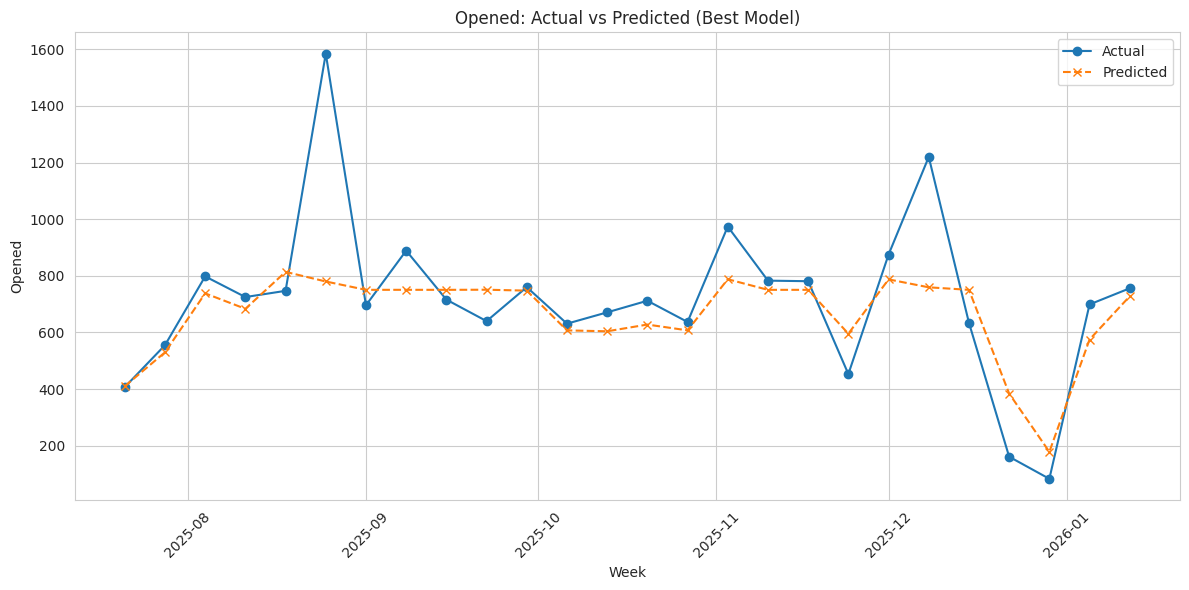

In [12]:
opened_results = tune_and_evaluate_model('opened', min_features=5, max_features=20)

Top 5 features → CV MAE: 27.885
Top 6 features → CV MAE: 27.407
Top 7 features → CV MAE: 28.207
Top 8 features → CV MAE: 30.877
Top 9 features → CV MAE: 29.502
Early stopping at 9 features (no improvement for 3 steps)

✅ Best features (6):
['closed_ewma_3', 'closed_roll_3', 'closed_roll_4', 'closed_lag_1', 'closed_lag_3', 'weekofyear']
⏱️ RF training time: 8.63s
⏱️ GB training time: 14.72s
⏱️ XGB training time: 4.00s
⏱️ RF metrics computation time: 0.36s
⏱️ GB metrics computation time: 1.91s
⏱️ XGB metrics computation time: 0.15s

⏱️ Total elapsed time: 35.30s

📊 MODEL COMPARISON
              model         MAE        RMSE        MAPE     CV_MAE     CV_STD  \
1                GB  147.808855  228.191317  228.191317  27.137617  12.587710   
2               XGB  165.939697  246.210966  246.210966  31.197042  15.952420   
0                RF  209.369918  287.438338  287.438338  41.112657   9.454904   
3  NAIVE (Baseline)  204.920000  284.692747         NaN  69.348066   0.000000   

   scor

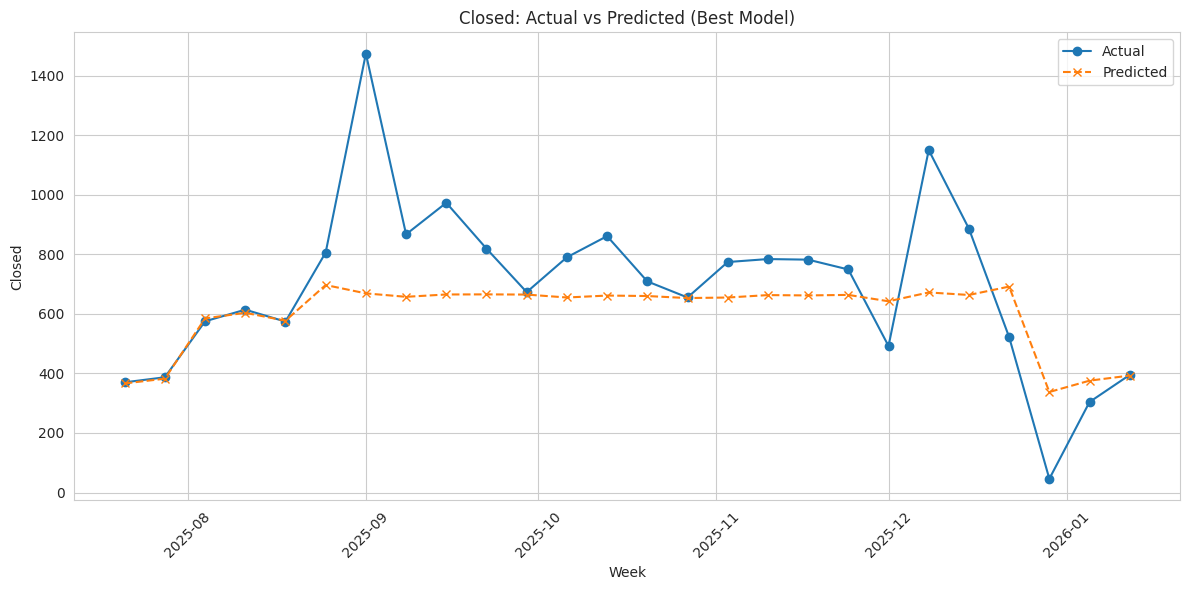

In [13]:
closed_results = tune_and_evaluate_model('closed', min_features=5, max_features=20)

**12. Backlog Predictions Using Best Models**


📦 BACKLOG PREDICTION PERFORMANCE
---------------------------------------------
MAE   : 769.43
RMSE  : 897.43
MBE   : 689.34
MAPE  : 41.89%


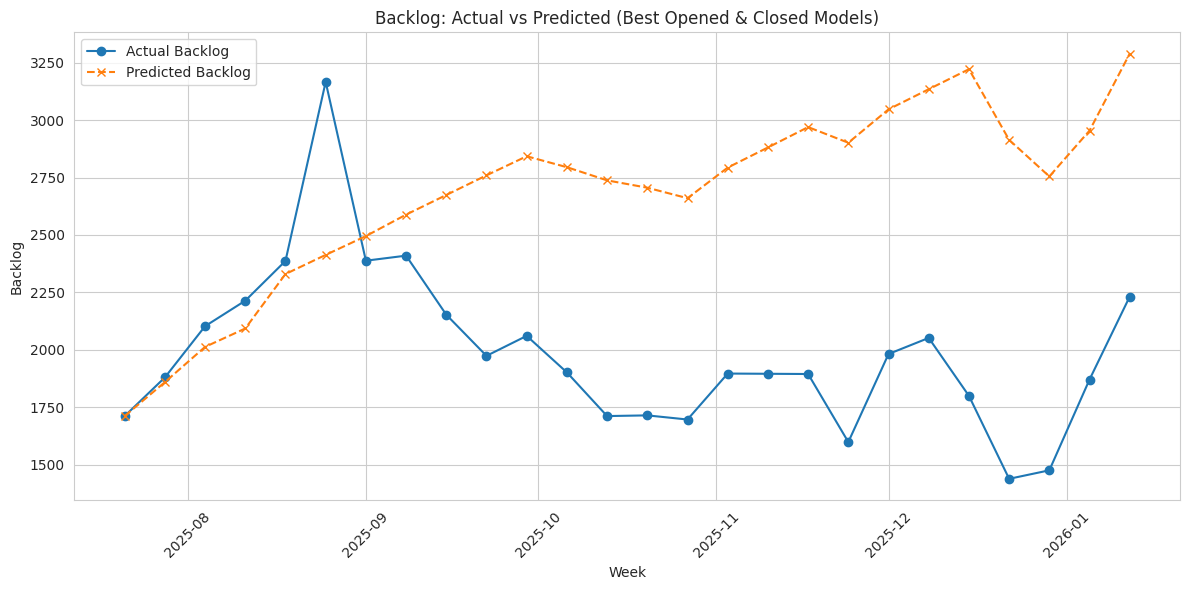

In [14]:
def evaluate_backlog(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mbe = np.mean(predicted - actual)  # bias

    mape = np.mean(
        np.abs((actual - predicted) / np.clip(actual, 1e-6, None))
    ) * 100

    return {
        'Backlog_MAE': mae,
        'Backlog_RMSE': rmse,
        'Backlog_MBE': mbe,
        'Backlog_MAPE_%': mape
    }

opened_model = opened_results['best_model']
closed_model = closed_results['best_model']
opened_features  = opened_results['selected_features']
closed_features = closed_results['selected_features']

timeline_test = test_df.copy()

timeline_test['opened_pred'] = opened_model.predict(
    timeline_test[opened_features]
)

timeline_test['closed_pred'] = closed_model.predict(
    timeline_test[closed_features]
)

timeline_test['backlog_pred'] = np.nan
timeline_test.iloc[0, timeline_test.columns.get_loc('backlog_pred')] = timeline_test.iloc[0]['backlog']

for i in range(1, len(timeline_test)):
    timeline_test.iloc[i, timeline_test.columns.get_loc('backlog_pred')] = (
        timeline_test.iloc[i-1]['backlog_pred']
        + timeline_test.iloc[i]['opened_pred']
        - timeline_test.iloc[i]['closed_pred']
    )

backlog_metrics = evaluate_backlog(
    timeline_test['backlog'],
    timeline_test['backlog_pred']
)

print("\n📦 BACKLOG PREDICTION PERFORMANCE")
print("-" * 45)
print(f"MAE   : {backlog_metrics['Backlog_MAE']:.2f}")
print(f"RMSE  : {backlog_metrics['Backlog_RMSE']:.2f}")
print(f"MBE   : {backlog_metrics['Backlog_MBE']:.2f}")
print(f"MAPE  : {backlog_metrics['Backlog_MAPE_%']:.2f}%")


plt.figure(figsize=(12,6))
plt.plot(timeline_test['week'], timeline_test['backlog'], label='Actual Backlog', marker='o')
plt.plot(timeline_test['week'], timeline_test['backlog_pred'], label='Predicted Backlog', linestyle='--', marker='x')
plt.xlabel("Week")
plt.ylabel("Backlog")
plt.title("Backlog: Actual vs Predicted (Best Opened & Closed Models)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()